In [68]:
import numpy as np
from visualise import plot_digi_fig
import matplotlib.pyplot as plt 
from dataloader import FFT_transform
from dataloader import FFT_transform_PM

In [69]:
#the following code is mainly based on code from https://www.datadriveninvestor.com/2020/10/23/fourier-transform-for-image-processing-in-python-from-scratch/
def distance(point1, point2):
    val=np.sqrt((point1[0]-point2[0])**2+point1[1]-point2[1]**2)
    val=np.nan_to_num(val)
    return val
    
def gaussianLP(D0,imgShape):
    base=np.zeros(imgShape[:2])
    rows,cols=imgShape[:2]
    center=(rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x]=np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianHP(D0,imgShape):
    base=np.zeros(imgShape[:2])
    rows,cols=imgShape[:2]
    center=(rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x]=1-np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base
       

<_io.TextIOWrapper name='Data/train_4.txt' mode='r' encoding='cp1252'>


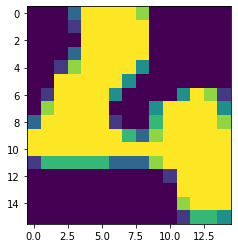

[[0 0 0 2 6 6 6 6 5 0 0 0 0 0 0]
 [0 0 0 1 6 6 6 6 6 0 0 0 0 0 0]
 [0 0 0 0 6 6 6 6 6 0 0 0 0 0 0]
 [0 0 0 2 6 6 6 6 6 0 0 0 0 0 0]
 [0 0 1 5 6 6 6 6 3 0 0 0 0 0 0]
 [0 0 6 6 6 6 6 3 0 0 0 0 0 0 0]
 [0 1 6 6 6 6 3 0 0 0 0 3 6 5 1]
 [0 5 6 6 6 6 0 0 0 3 6 6 6 6 3]
 [2 6 6 6 6 6 1 0 0 4 6 6 6 6 5]
 [6 6 6 6 6 6 6 4 2 5 6 6 6 6 6]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
 [1 4 4 4 4 4 2 2 2 5 6 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 1 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 1 4 4 3]]
15
16
[[ 14.0316923   27.88545373  29.44438979  53.36993927  40.73165967
   57.24540879  40.56166174  32.18875825  40.56166174  57.24540879
   40.73165967  53.36993927  29.44438979  27.88545373  14.0316923 ]
 [ 33.79756238  24.8576734   -6.92848349  34.47647639  41.5457205
   43.93725079  55.86817187  53.96804565  55.23427186  37.30862828
   48.40728876  48.23104217  47.07978826  16.32305005  24.3644241 ]
 [ 19.90382973  33.29069506  14.53990846  36.50090633  41.3553

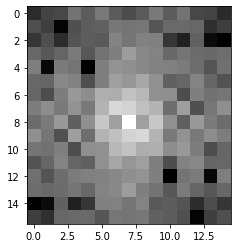

In [70]:
#this is a visualization of one of our examples. Please note that the line fshift = np.fft.fftshift(fft_data) in the code of the 
#FFT_transform in dataloader (at least in the version I use) is centering the low frequency band. So what you see here is that we
#have the highest amplitude (lightest squeres) in the center which means in the low frequency band
with open('Data/train_4.txt') as f:
    print(f)
    for line in f:
        curr = line.strip()
        mat = np.fromstring(curr, dtype=int, sep='  ')
        mat_r = np.reshape(mat, (-1, 15))
        plot_digi_fig(mat_r)
        print(mat_r)
        print(len(mat_r[0]))
        print(len(mat_r))
        mag_val = FFT_transform(mat_r)
        plt.imshow(mag_val, "gray")
        print(mag_val)
        len(mag_val)
        print(len(mag_val[0]))
        break
    

<function matplotlib.pyplot.show(close=None, block=None)>

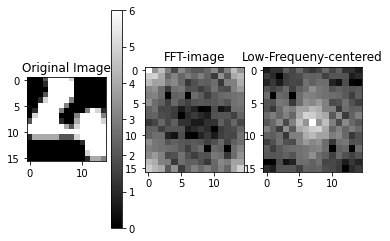

In [72]:
#to test this we use again code from the blog mentioned above to apply a low and a high pass filter to our data
original=np.fft.fft2(mat_r)
center=np.fft.fftshift(original)
#print the original image
plt.subplot(131),plt.imshow(mat_r, "gray"), plt.title("Original Image"),plt.colorbar()
#print the fast fourier transform
plt.subplot(132),plt.imshow(np.log(1+np.abs(original)), "gray"), plt.title("FFT-image")
#print the fast fourier transform with the low-frequency centered
plt.subplot(133),plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Low-Frequeny-centered")
plt.show


(<AxesSubplot:title={'center':'High Pass-freqeuncy'}>,
 Text(0.5, 1.0, 'High Pass-freqeuncy'))

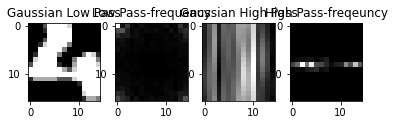

In [74]:
#here we apply a low pass gaussian filter
LowPassCenter=center*gaussianLP(50,mat_r.shape)
LowPass=np.fft.ifftshift(LowPassCenter)
inverse_LowPass=np.fft.ifft2(LowPass)

#we plot the reconstructed image
plt.subplot(141), plt.imshow(np.abs(inverse_LowPass),"gray"),plt.title("Gaussian Low Pass")
#print(np.abs(LowPass)<np.abs(center))
#we plot the image in the frequency domain. You can see that the middle which corresponds to the high-pass regions are filtered out
plt.subplot(142), plt.imshow(np.abs(LowPass),"gray"),plt.title("Low Pass-frequency")

#here we apply a high pass gaussian filter
HighPassCenter=center*gaussianHP(50,mat_r.shape)
HighPass=np.fft.ifftshift(HighPassCenter)
inverse_HighPass=np.fft.ifft2(HighPass)
#we plot the reconstructed image
plt.subplot(143), plt.imshow(np.abs(inverse_HighPass),"gray"),plt.title("Gaussian High Pass")

#we plot the image in the frequency domain. You can see that everything but the middle which corresponds to the high-pass regions are filtered out
plt.subplot(144), plt.imshow(np.abs(HighPass),"gray"),plt.title("High Pass-freqeuncy")

In [58]:
#this is some experiment I started. to begin with I again process the training and test data set
import os
import pandas as pd
import numpy as np
from visualise import plot_digi_fig
import matplotlib.pyplot as plt
from dataloader import FFT_transform
#from dataloader import FFT_transform_PM

entries = os.listdir('Data/')
#print(entries)
train_data=[k for k in entries if 'train' in k]
#print(train_data)
X_title_train=[]
flat_data_train=[]
X_data_train = []
X_data_train_phase=[]
flat_data_train_phase=[]
for entry in train_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))

            #here we apply the FFT transform
            mag_val = FFT_transform(mat_r)
            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_train.append(mag_val)
            X_data_train_phase.append(phase_val)
            X_title_train.append(name)
            flat_data_train.append(mag_val.flatten())
            flat_data_train_phase.append(phase_val.flatten())
    #X_data_train.append(mag_val)
    #X_data.append (image)
test_data=[k for k in entries if 'test' in k]
#print(test_data)
X_title_test=[]
X_data_test = []
flat_data_test=[]
X_data_test_phase=[]
flat_data_test_phase=[]
for entry in test_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))


            mag_val = FFT_transform(mat_r)
            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_test.append(mag_val)
            X_data_test_phase.append(phase_val)
            X_title_test.append(name)
            flat_data_test.append(mag_val.flatten())
            flat_data_test_phase.append(phase_val.flatten())
    #X_data.append (image)


#calculate the labels of the data
res_train=[]
res_train = [sub.replace('.txt', '') for sub in X_title_train]
res_train = [sub.replace('train_', '') for sub in res_train]
res_train = [eval(i) for i in res_train]
X_train_lable=res_train
res_test=[]
res_test = [sub.replace('.txt', '') for sub in X_title_test]
res_test = [sub.replace('test_', '') for sub in res_test]
res_test = [eval(i) for i in res_test]
X_test_lable=res_test
#print(res_test)
#print(X_title_train)

#train a simple ML algorithm here SVM:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import math
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore') # I use that here as the GridSearchCV function generates a number of warning cluttering your console

# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
param_grid={'C':[0.1,100],'gamma':[0.0001,0.001],'kernel':['poly']}

svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)
model2=GridSearchCV(svc,param_grid)

x_train=flat_data_train
x_train_phase= flat_data_train_phase # added the phase values 
#here I just convert nan to numbers but we might want to look deeper into where the nan values are coming from in the first place
x_train=np.nan_to_num(x_train)
x_train_phase = np.nan_to_num(x_train_phase)
#print(len(flat_data_train))
y_train=X_train_lable
#print(len(y_train))
x_test=flat_data_test
x_test_phase = flat_data_test_phase
x_test=np.nan_to_num(x_test)
x_test_phase= np.nan_to_num(x_test_phase)
y_test=X_test_lable

C:\Users\sophi\Dokumente\Master\Master\Groningen\Machine Learning\dataloader.py:11: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))
C:\Users\sophi\Dokumente\Master\Master\Groningen\Machine Learning\dataloader.py:19: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(fshift))


In [59]:
#here the question is what happens if we evaluate how a simple logistic classifier performs if we leave out one frequency?

feature_evaluation_array=np.zeros(240)
for i in range(240):
    del_x_train=x_train.copy()
    del_x_train=np.delete(del_x_train,i,1)

    del_x_test=x_test.copy()
    del_x_test=np.delete(del_x_test,i,1)

    logR = LogisticRegression()
    #logR2= LogisticRegression()
    #parameters_lr = {
        #'penalty' : ['l1','l2'], 
        #'C'       : np.logspace(-3,3,7),
        #'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}

    #lrGrid1 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # here I only selected 2 iteration of the CV as higher values significantly increase the computation time
    #lrGrid2 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # See above

    #lr_amp = lrGrid1
    #lr_phs = lrGrid2


    #lr_amp.fit(x_train,y_train)
    #lr_phs.fit(x_train_phase,y_train)



    #check accuracy without parameter tuning for amplitude
    test_np = logR.fit(del_x_train,y_train)
    amp_pred_np= test_np.predict(del_x_test)
    #check predictions with tunned model
    #amp_pred_p= lr_amp.predict(x_test)

    #check accuracy without parameter tuning for phase
    #test_np = logR2.fit(x_train_phase,y_train)
    #phs_pred_np= test_np.predict(x_test_phase)
    #check predictions with tunned model
    #phs_pred_p= lr_phs.predict(x_test_phase)
    feature_evaluation_array[i]=sum(amp_pred_np==y_test)/len(y_test)*100

    print("LR:for feature"+str(i))
    print(round(sum(amp_pred_np==y_test)/len(y_test)*100,1))


LR:for feature0
71.8
LR:for feature1
71.9
LR:for feature2
70.5
LR:for feature3
72.0
LR:for feature4
71.9
LR:for feature5
72.2
LR:for feature6
72.5
LR:for feature7
70.7
LR:for feature8
72.5
LR:for feature9
72.2
LR:for feature10
71.9
LR:for feature11
72.0
LR:for feature12
70.5
LR:for feature13
71.9
LR:for feature14
71.8
LR:for feature15
71.8
LR:for feature16
72.4
LR:for feature17
72.2
LR:for feature18
72.1
LR:for feature19
71.9
LR:for feature20
72.0
LR:for feature21
72.4
LR:for feature22
72.2
LR:for feature23
70.0
LR:for feature24
71.7
LR:for feature25
71.5
LR:for feature26
71.5
LR:for feature27
70.9
LR:for feature28
72.4
LR:for feature29
71.8
LR:for feature30
72.6
LR:for feature31
71.3
LR:for feature32
71.0
LR:for feature33
71.4
LR:for feature34
71.4
LR:for feature35
71.4
LR:for feature36
72.8
LR:for feature37
71.8
LR:for feature38
70.7
LR:for feature39
71.7
LR:for feature40
71.8
LR:for feature41
72.0
LR:for feature42
72.3
LR:for feature43
72.5
LR:for feature44
71.6
LR:for feature45
71.

(<matplotlib.image.AxesImage at 0x21b2f34ab20>,
 <matplotlib.colorbar.Colorbar at 0x21b2f34afa0>)

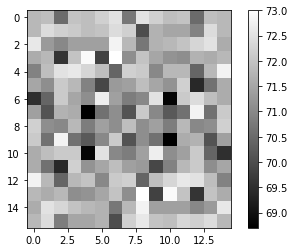

In [76]:
#I plot the accuracy for every frequency. I have to admit this is not a nice pattern.
var=feature_evaluation_array.reshape(16,15)
plt.imshow(var, "gray"),plt.colorbar()

In [62]:
#okay alternative experiment:
#here the question is what happens if we evaluate how a simple logistic classifier performs if we only use one frequency to classify the image?

feature_evaluation_array_2=np.zeros(240)
for i in range(240):
    del_x_train=x_train.copy()
    del_x_train= del_x_train[:,i]
    del_x_train=del_x_train.reshape(-1, 1)
    del_x_test=x_test.copy()
    del_x_test= del_x_test[:,i]
    del_x_test=del_x_test.reshape(-1, 1)

    logR = LogisticRegression()
    #logR2= LogisticRegression()
    #parameters_lr = {
        #'penalty' : ['l1','l2'], 
        #'C'       : np.logspace(-3,3,7),
        #'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}

    #lrGrid1 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # here I only selected 2 iteration of the CV as higher values significantly increase the computation time
    #lrGrid2 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # See above

    #lr_amp = lrGrid1
    #lr_phs = lrGrid2


    #lr_amp.fit(x_train,y_train)
    #lr_phs.fit(x_train_phase,y_train)



    #check accuracy without parameter tuning for amplitude
    test_np = logR.fit(del_x_train,y_train)
    amp_pred_np= test_np.predict(del_x_test)
    #check predictions with tunned model
    #amp_pred_p= lr_amp.predict(x_test)

    #check accuracy without parameter tuning for phase
    #test_np = logR2.fit(x_train_phase,y_train)
    #phs_pred_np= test_np.predict(x_test_phase)
    #check predictions with tunned model
    #phs_pred_p= lr_phs.predict(x_test_phase)
    feature_evaluation_array_2[i]=sum(amp_pred_np==y_test)/len(y_test)*100

    print("LR:for feature"+str(i))
    print(round(sum(amp_pred_np==y_test)/len(y_test)*100,1))


LR:for feature0
11.5
LR:for feature1
12.3
LR:for feature2
11.8
LR:for feature3
12.5
LR:for feature4
10.9
LR:for feature5
10.8
LR:for feature6
13.3
LR:for feature7
15.8
LR:for feature8
13.3
LR:for feature9
10.8
LR:for feature10
10.9
LR:for feature11
12.5
LR:for feature12
11.8
LR:for feature13
12.3
LR:for feature14
11.5
LR:for feature15
13.0
LR:for feature16
11.0
LR:for feature17
11.1
LR:for feature18
12.3
LR:for feature19
12.5
LR:for feature20
12.9
LR:for feature21
13.5
LR:for feature22
15.4
LR:for feature23
11.6
LR:for feature24
12.3
LR:for feature25
12.0
LR:for feature26
13.1
LR:for feature27
14.6
LR:for feature28
12.4
LR:for feature29
12.5
LR:for feature30
12.5
LR:for feature31
10.9
LR:for feature32
13.5
LR:for feature33
14.0
LR:for feature34
12.0
LR:for feature35
10.8
LR:for feature36
12.2
LR:for feature37
13.0
LR:for feature38
12.2
LR:for feature39
11.7
LR:for feature40
14.5
LR:for feature41
13.5
LR:for feature42
15.7
LR:for feature43
10.7
LR:for feature44
11.4
LR:for feature45
12.

(<matplotlib.image.AxesImage at 0x21b2f28e400>,
 <matplotlib.colorbar.Colorbar at 0x21b2f2a9580>)

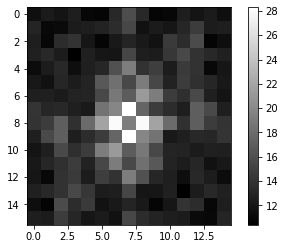

In [75]:
#again I plot the prediction accuracy for every frequency. Here the low-frequency is represented in the middle and the high frequency
#in the corners (as this is based on our original implementation). I want to claim that you can see that the high freqency is
#indeed not really important as the corners are dark.but that the low frequency is important for classifying the data
#let me know if you have an interpretation of this image
var2=feature_evaluation_array_2.reshape(16,15)
plt.imshow(var2, "gray"),plt.colorbar()